# Image classification for Medical Image

以下將演示如何使用 huggingface 框架並使用其中提供的函數載入自定義的資料集，以達到影像分類的結果。

huggingface 的工作流程：
![](https://hackmd.io/_uploads/HkEzgZdwh.png)

In [1]:
# 安裝所需套件
!pip -q install transformers==4.28.1 datasets evaluate

In [2]:
# 匯入相關套件
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

## Load dataset

In [3]:
from datasets import load_dataset

dataset = load_dataset("/home/jovyan/ta-shared-ii/datas/NIH_data_1800")

Resolving data files:   0%|          | 0/1200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/300 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/300 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/jovyan/.cache/huggingface/datasets/imagefolder/NIH_data_1800-222e704d8a3d3adc/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1200
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 300
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 300
    })
})

In [7]:
train_dataset = dataset['train']
valid_dataset = dataset['validation']

In [8]:
item = next(iter(train_dataset))

0


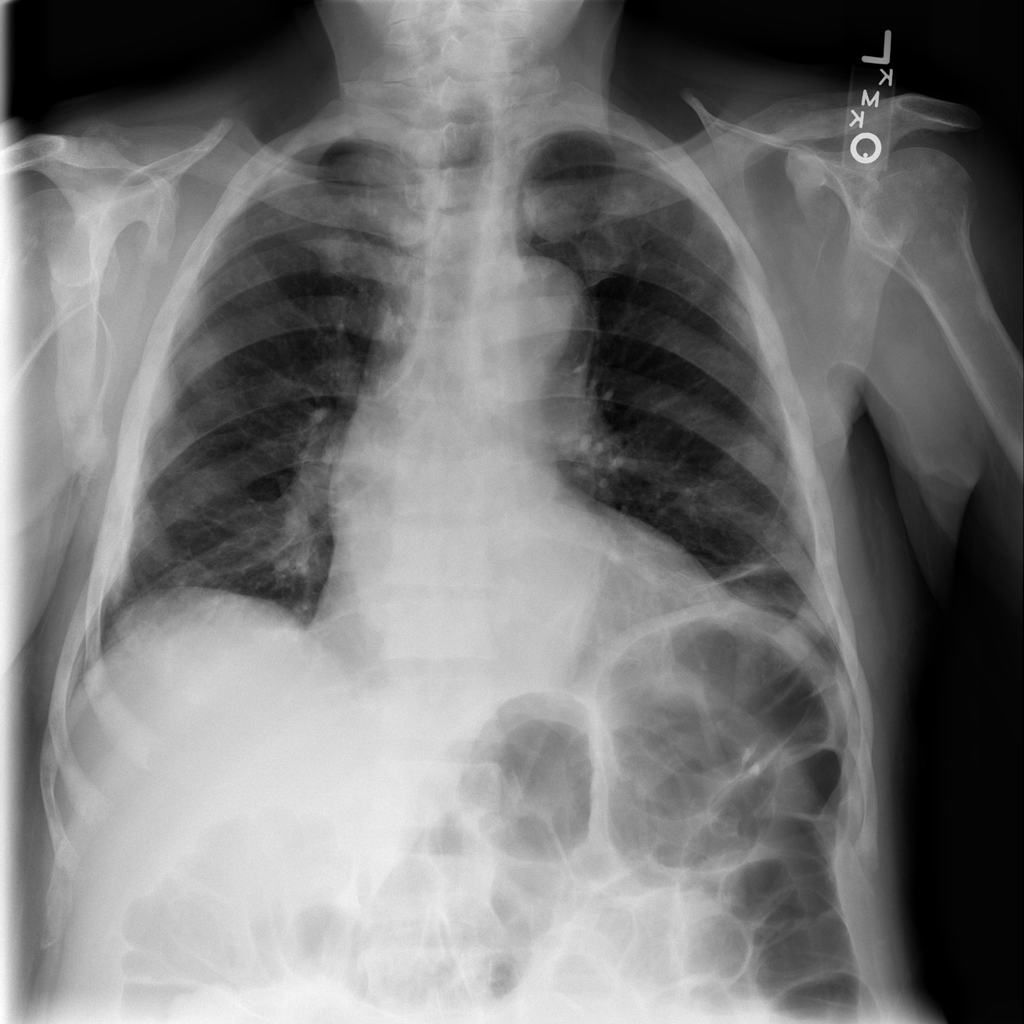

In [9]:
print(item['label'])
item['image']

In [10]:
train_dataset.features["label"].names

['Atelectasis', 'Effusion', 'NoFinding']

In [11]:
labels = train_dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [12]:
labels

['Atelectasis', 'Effusion', 'NoFinding']

現在，按照標籤 id 轉換成名稱：

In [13]:
id2label[1]

'Effusion'

## Preprocess


接下來的步驟是載入指定模型使用的影像處理器，將影像處理成張量：

In [14]:
from transformers import AutoImageProcessor

# checkpoint = "google/vit-base-patch16-224-in21k"  # model name
# checkpoint = "google/efficientnet-b6"
checkpoint = "microsoft/cvt-13"
# checkpoint = "microsoft/resnet-50"
# checkpoint = "facebook/convnext-tiny-224"
# checkpoint = "facebook/convnext-base-224"
# # checkpoint = "facebook/convnext-large-224"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [15]:
image_processor

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

---
將影像進行轉換，使模型更具一般性以應付過擬合的情況。這裡會使用的 torchvision 中 transforms 的模組，但也能替換成其他適用的影像處理套件。

將其調整影像大小以及隨機仿射處理，並使用影像的平均值和標準差進行標準化：

In [16]:
from torchvision.transforms import Resize, RandomAffine, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([Resize(size),
#                        RandomHorizontalFlip(),
                       RandomAffine(degrees=10, scale=(0.9, 1.1)),
                       ToTensor(),
                       normalize])

接下來創建一個預處理函數，轉換並回傳影像的像素值作為模型的輸入：

In [17]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

要在整個資料集上應用預處理函數，可以使用 Hugging Face 資料集的 [with_transform](https://huggingface.co/docs/datasets/v2.11.0/en/package_reference/main_classes#datasets.Dataset.with_transform) 方法。當載入資料集的一個元素時，轉換會即時套用：

In [18]:
train_ds = train_dataset.with_transform(transforms)
valid_ds = valid_dataset.with_transform(transforms)

In [19]:
import matplotlib.pyplot as plt
import torch

In [20]:
item = next(iter(train_ds))

In [21]:
item

{'label': 0,
 'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
torch.Size([3, 224, 224])


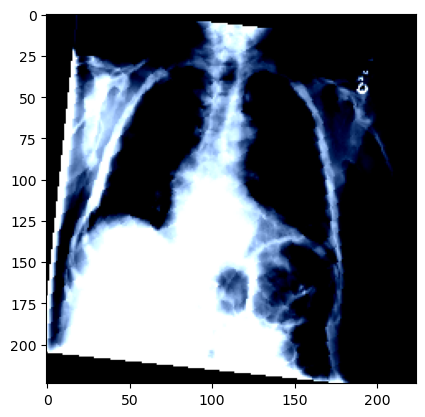

In [22]:
print(item['label'])
print(item['pixel_values'].size())
plt.imshow(torch.permute(item['pixel_values'], (1, 2, 0)))

現在使用 [DefaultDataCollator](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/data_collator#transformers.DefaultDataCollator) 創建一個批次樣本。與 Hugging face 裡 Transformers 的其他資料收集器不同，DefaultDataCollator 不會套用額外的預處理，例如填充（padding）。

In [23]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

## Evaluate

在訓練過程中加入評估指標通常有助於評估模型的表現。可以使用 Hugging Face 的 [Evaluate](https://huggingface.co/docs/evaluate/index) 函式庫快速載入評估方法。在此任務上載入 [accuracy](https://huggingface.co/spaces/evaluate-metric/accuracy) 指標（請參閱 Hugging Face 的 Evaluate [快速導覽](https://huggingface.co/docs/evaluate/a_quick_tour)，以了解如何載入和計算指標的詳細資訊）：

In [24]:
import evaluate

accuracy = evaluate.load("accuracy")

然後創建一個函數，將預測及標籤使用 [compute](https://huggingface.co/docs/evaluate/v0.4.0/en/package_reference/main_classes#evaluate.EvaluationModule.compute) 以計算準確度：

In [25]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

現在已準備好開始訓練模型了！使用 [AutoModelForImageClassification](https://huggingface.co/docs/transformers/v4.28.1/en/model_doc/auto#transformers.AutoModelForImageClassification) 載入模型。指定標籤的數量以及標籤的對應方式：

In [30]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # 預訓練模型的分類數量與自定義的資料集不同時使用
)

Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-13 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([3, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


接著的階段，只剩以下三個步驟：

1. 在 [TrainingArguments](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.TrainingArguments) 中定義訓練的超參數。請務必留意資料集中未使用的資訊，設定 remove_unused_columns=False 可以防止被刪除未使用到的資訊！例如 image，這會導致無法獲得 pixel_values。另一個必需設定的參數是 output_dir，指定模型儲存的位置。通過設定 push_to_hub=True 將模型上傳至 Hub（需要登入 Hugging Face 才能上傳模型）。在每個 epoch 結束時，[Trainer](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.Trainer) 將評估準確性並儲存訓練模型。
2. 將訓練參數、模型、資料集、預處理器、資料收集器以及計算評估指標函數傳遞給 [Trainer](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.Trainer)。
3. 呼叫 [train](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.Trainer.train) 來微調模型。

In [31]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="my_cvt_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy")

In [32]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

In [33]:
from transformers.integrations import MLflowCallback
trainer.remove_callback(MLflowCallback)
trainer.train()

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.056400,0.931923,0.573333
2,0.977100,0.894381,0.580000
3,0.955700,0.895632,0.586667
4,0.907500,0.849428,0.610000
5,0.913300,0.866238,0.613333
6,0.866000,0.863966,0.613333
7,0.838000,0.847387,0.613333
8,0.832300,0.819117,0.650000
9,0.821400,0.860314,0.610000
10,0.815700,0.837828,0.613333


TrainOutput(global_step=380, training_loss=0.8983376854344418, metrics={'train_runtime': 528.3036, 'train_samples_per_second': 22.714, 'train_steps_per_second': 0.719, 'total_flos': 2.1257288994816e+17, 'train_loss': 0.8983376854344418, 'epoch': 10.0})

## Inference

現在，微調後的模型以存放在指定路徑，並可使用它來進行推論！

載入想要進行推論的影像：

In [34]:
test_dataset = dataset['test']
image = test_dataset['image'][0]
label = test_dataset['label'][0]

In [35]:
label

0

In [36]:
id2label[label]

'Atelectasis'

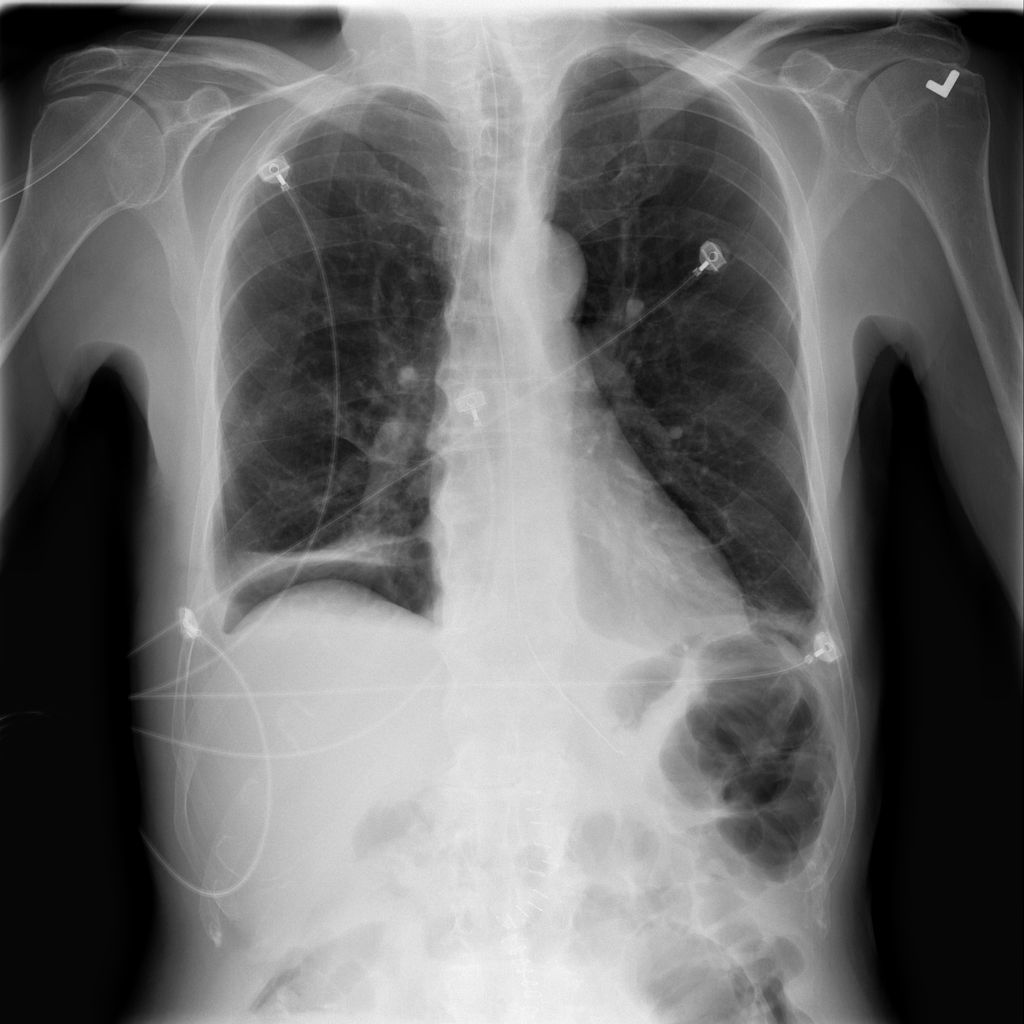

In [37]:
image

使用微調後的模型進行推論最簡單的方法是在 pipline() 中設定。藉由指定的模型建構一個影像分類的 pipeline，然後將影像傳遞給它：

In [38]:
from transformers import pipeline

classifier = pipeline("image-classification", model="my_cvt_model/checkpoint-380/")
classifier(image)

[{'score': 0.7898798584938049, 'label': 'Effusion'},
 {'score': 0.16112428903579712, 'label': 'Atelectasis'},
 {'score': 0.04899587854743004, 'label': 'NoFinding'}]

載入影像處理器對影像進行預處理，並以 PyTorch 的張量型態回傳作為輸入：

In [39]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("my_cvt_model/checkpoint-380/")
inputs = image_processor(image.convert('RGB'), return_tensors="pt")

In [40]:
inputs

{'pixel_values': tensor([[[[-1.2445, -1.0904, -1.0733,  ..., -0.8507, -0.8507, -0.9705],
          [-1.2103, -1.1932, -1.1418,  ..., -0.7822, -0.0801, -0.5767],
          [-1.2103, -1.0390, -0.9877,  ...,  0.2967,  1.2385,  0.4679],
          ...,
          [-2.0152, -2.0152, -2.0152,  ..., -2.0152, -2.0152, -2.0152],
          [-2.0152, -2.0152, -2.0152,  ..., -2.0152, -2.0152, -2.0152],
          [-2.0152, -2.0152, -2.0152,  ..., -2.0152, -2.0152, -2.0152]],

         [[-1.1429, -0.9853, -0.9678,  ..., -0.7402, -0.7402, -0.8627],
          [-1.1078, -1.0903, -1.0378,  ..., -0.6702,  0.0476, -0.4601],
          [-1.1078, -0.9328, -0.8803,  ...,  0.4328,  1.3957,  0.6078],
          ...,
          [-1.9307, -1.9307, -1.9307,  ..., -1.9307, -1.9307, -1.9307],
          [-1.9307, -1.9307, -1.9307,  ..., -1.9307, -1.9307, -1.9307],
          [-1.9307, -1.9307, -1.9307,  ..., -1.9307, -1.9307, -1.9307]],

         [[-0.9156, -0.7587, -0.7413,  ..., -0.5147, -0.5147, -0.6367],
          [-0

將輸入傳遞給模型，並回傳 logits（尚未經過 softmax）：

In [41]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("my_cvt_model/checkpoint-380/")
with torch.no_grad():
    logits = model(**inputs).logits

In [42]:
predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]

'Effusion'

## Explainable AI

可解釋性人工智慧（Explainable AI）是指能夠解釋和解釋其結論、推論和決策過程的人工智慧系統。傳統上，許多機器學習和深度學習模型往往被視為黑盒，它們可以對數據進行複雜的計算，但很難理解為什麼做出特定的預測或決策。

其中 GradCAM（Gradient-weighted Class Activation Mapping）用於視覺任務中對深度學習模型的解釋。它可以幫助我們理解模型在圖像分類或物體檢測等任務中的決策過程，並提供對模型預測的視覺化解釋。

![](https://hackmd.io/_uploads/Syf544uP3.png)

以下是使用 GradCAM 進行可解釋性 AI 的基本步驟：

1. 準備模型：首先，需要準備一個已經訓練好的深度學習模型，例如卷積神經網絡（CNN）用於圖像分類。
2. 特徵提取：通過將圖像輸入模型，獲得中間層的特徵圖。這些特徵圖是在網絡中不同層次上提取的高級視覺特徵。
3. 梯度計算：對於目標類別，計算反向傳播的梯度。這些梯度表示目標類別相對於特徵圖的重要性。
4. 特徵加權：將梯度與特徵圖進行加權相乘，以強調對目標類別貢獻最大的區域。
5. 生成顯著性圖：將加權特徵圖進行空間平均或加總，得到一個顯著性圖，表示模型對於不同區域的關注程度。
6. 視覺化解釋：將顯著性圖與原始圖像進行融合或覆蓋，生成一張視覺化的解釋圖。這個解釋圖可以顯示出模型在預測中關注的重要區域。

In [44]:
# 安裝支援 PyTorch 的 GradCAM 套件
!pip -q install grad-cam

In [45]:
# 匯入相關套件
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from typing import List, Callable, Optional
from PIL import Image
import cv2

from torchvision.transforms import ToPILImage
from functools import partial

In [46]:
# 按照不同的模型選定 reshape 的方式
def reshape_transform_cvt_huggingface(tensor, model, width, height):
    tensor = tensor[:, 1 :, :]  # remove 1 cls token
    tensor = tensor.reshape(tensor.size(0),
                            height,
                            width,
                            tensor.size(-1))
    
    # https://github.com/huggingface/transformers/blob/a2c90a7f7b1f8a2a8217c962a04a1a65638121d5/src/transformers/models/cvt/modeling_cvt.py#L699
    norm = model.layernorm(tensor)
    return norm.transpose(2, 3).transpose(1, 2)  # (Batch, features, height, width)

In [47]:
def reshape_gradcam_transform_cvt_huggingface(tensor, model, width, height):
    tensor = tensor[:, 1 :, :]  # remove 1 cls token
    tensor = tensor.reshape(tensor.size(0),
                            height,
                            width,
                            tensor.size(-1))
    return tensor.transpose(2, 3).transpose(1, 2)  # (Batch, features, height, width)

In [48]:
# 拿取模型輸出的 logits
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

In [101]:
def run_grad_cam_on_image(model, #: torch.nn.Module,
                          target_layer, #: torch.nn.Module,
                          targets_for_gradcam, #: List[Callable],
                          reshape_transform, #: Optional[Callable],
                          input_tensor=img_tensor, #: torch.nn.Module=img_tensor,
                          input_image=image, #: Image=image,
                          method=GradCAM): #: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        # Replicate the tensor for each of the categories we want to create Grad-CAM for:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            # convert graycam size to input image size
            grayscale_cam = cv2.resize(grayscale_cam, input_image.size) 
            
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook:
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)

---

選定一張影像作為演示

In [92]:
image = dataset['test']["image"][0]
label = dataset['test']['label'][0]

img_tensor = Compose([Resize(size), ToTensor(), normalize])(image.convert("RGB"))

In [97]:
label

0

In [98]:
img_tensor.shape

torch.Size([3, 224, 224])

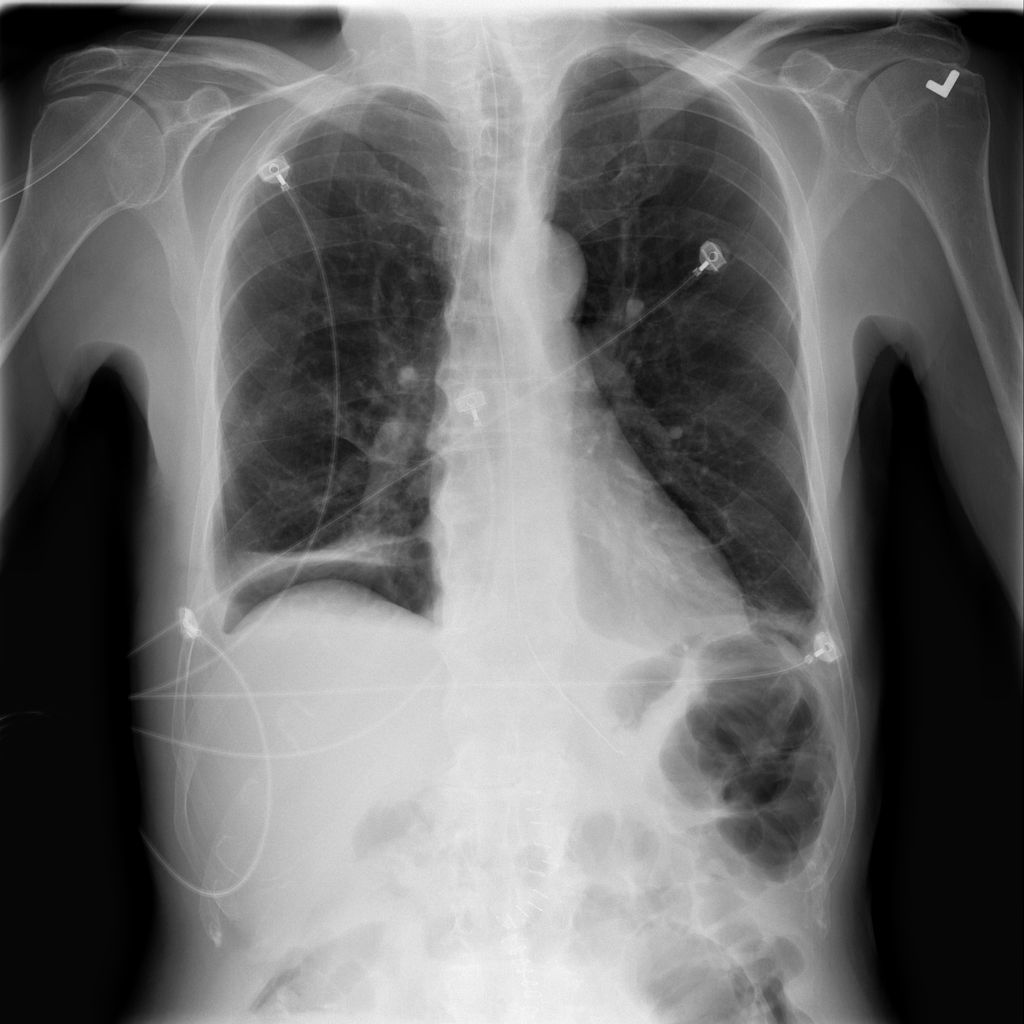

In [99]:
image

In [102]:
targets_for_gradcam = [ClassifierOutputTarget(label2id['Atelectasis']),
                       ClassifierOutputTarget(label2id['Effusion']),
                       ClassifierOutputTarget(label2id['NoFinding'])]

In [103]:
reshape_transform_gradcam = partial(reshape_gradcam_transform_cvt_huggingface,
                            model=model,
                            width=img_tensor.shape[2]//16,
                            height=img_tensor.shape[1]//16)

* ### 如何知道應該選擇哪個目標層？**選擇在分類器或池化層之前的最後一層**

In [104]:
model

CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [105]:
target_layer_gradcam = model.cvt.encoder.stages[-1].layers[-2]

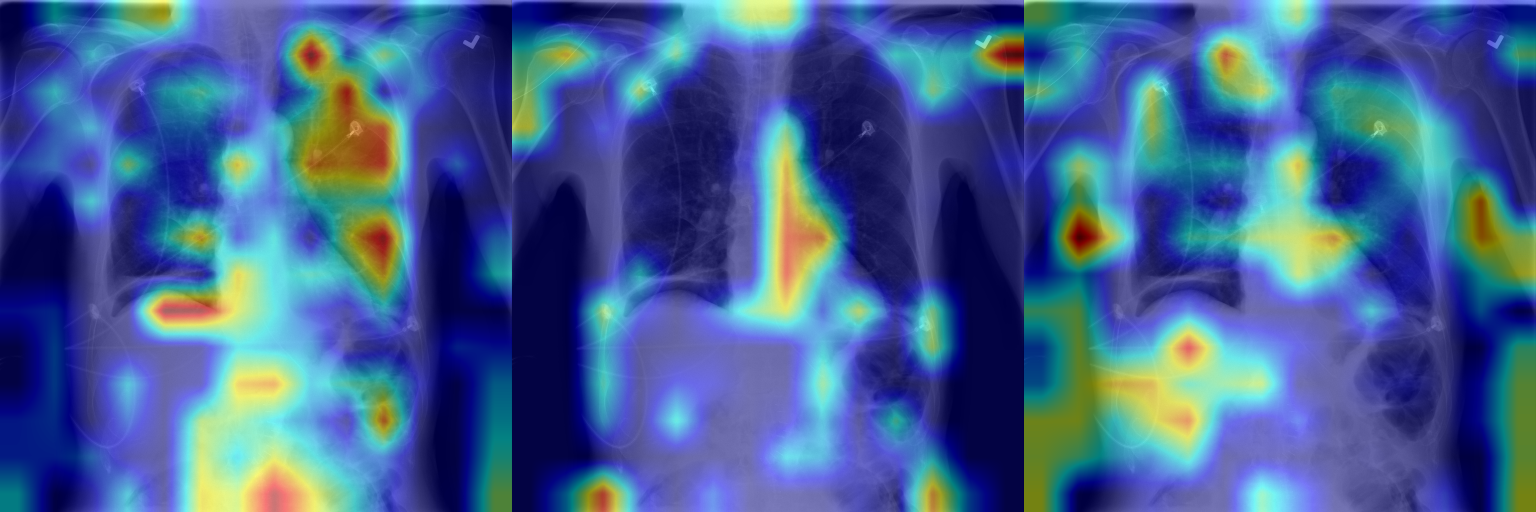

In [106]:
display(Image.fromarray(run_grad_cam_on_image(model=model,
                                              target_layer=target_layer_gradcam,
                                              targets_for_gradcam=targets_for_gradcam,
                                              reshape_transform=reshape_transform_gradcam,
                                              input_image=image.convert('RGB'),
                                              input_tensor=img_tensor)))

In [90]:
from pytorch_grad_cam import ScoreCAM

ScoreCAM（Score-based Class Activation Mapping）和 GradCAM（Gradient-weighted Class Activation Mapping）都是解釋卷積神經網絡（CNN）模型的可視化方法，用於可視化模型對圖像中不同區域的關注程度。它們的主要區別在於**權重的計算方式**和**解釋的焦點**。

100%|██████████| 24/24 [00:07<00:00,  3.15it/s]


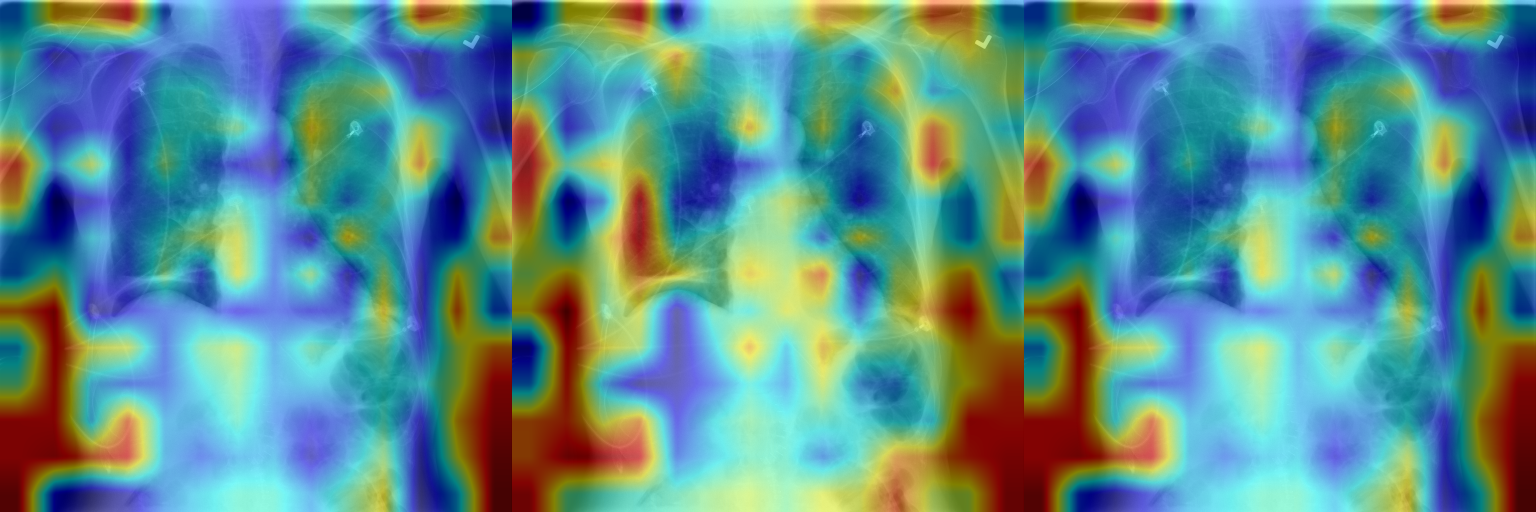

In [107]:
display(Image.fromarray(run_grad_cam_on_image(model=model,
                                              target_layer=target_layer_gradcam,
                                              targets_for_gradcam=targets_for_gradcam,
                                              reshape_transform=reshape_transform_gradcam,
                                              input_image=image.convert('RGB'),
                                              input_tensor=img_tensor,
                                              method=ScoreCAM)))

* Reference tutorial: https://jacobgil.github.io/pytorch-gradcam-book/HuggingFace.html